<div class="alert alert-block alert-info" style="text-align: center; color: black">
    <h1 style="color: #002AFF">A Butterfly in COVID:<br>Structural Racism and Baltimore's Pretrial Legal System</h1>
    <h2>Code Supporting Article Analysis and Images</h2>
</div>


<p> This notebook is the source of data, analysis, and code behind the claims made in <span style="font-weight: bold">A Butterfly in COVID: Structural Racism and Baltimore's Pretrial Legal System</span> by Doug Colbert and Colin Starger. The code is written in Python.</p>

<p>To assist in verification, the notebook refers directly to <span style="font-weight: bold">FOOTNOTES</span> in the article where claims are made. In addition, <span style="font-weight: bold">FIGURES</span> are also separatedly labelled with large headers.</p>

<p>This version of the Notebook is keyed off of the <span style="color:orange">MLR Edits Second Round Author Reivew</span>. This GitHub repo is referred to in FOOTNOTE 5 of the paper.</p>

<h2 style="text-align: center; color: red">SET UP FUNCTIONS</h2>

In [1]:
#Libraries
import requests
import pandas as pd # make sure you have v 1.1.0 of Pandas or later
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import datetime as dt
from datetime import date
from geopandas import GeoDataFrame
from shapely.geometry import Polygon, LineString, Point
from shapely import wkt

In [2]:
#Load API information for BNIA indicators
#Will use for helping with ShortName
api_df = pd.read_csv("VS-Indicator-APIs.csv")
api_df.set_index("ShortName", inplace=True) #Makes the dataframe index the shortname
api_df.head(2) #This code simply shows the first two rows of the file

,Indicator Number,Indicator,Section,API
ShortName,,,,
tpopXX,1,Total Population,Census Demographics,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...
maleXX,2,Total Male Population,Census Demographics,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...


In [3]:
#Functions to access the BNIA API
def getGDFfromURL(url, layer=0):
    #GDF stands for GeoDataFrame; this is the innermost function called by getGDF
    tail = "/"+str(layer)+"/query?where=1%3D1&outFields=*&outSR=4326&f=json" #worked this out
    url+=tail
    print(url)
    gdf = gpd.read_file(url) #GeoPandas has a built in function to read APIs given right URL
    return gdf

def getGDF(shortname, level=0):
    #This is outermost function called by user; it calls getGDFfromURL
    url = api_df.loc[shortname, "API"]
    return getGDFfromURL(url, level)

In [4]:
#Global vars

#List of "reverse indicators" - where LESS should be lighter (as opposed to standard MORE=lighter)
reverse_list=["kraXX", "hfaiXX", "regvoteXX", "pwhiteXX", "mhhiXX", "ownrocXX", "lifexpXX", "votedXX", 'libcardXX', 'hfaiXX', 'readyXX']

#Need this for REVERSE cmaps (without reference to the XX)
new_reverse_list=[]
for r in reverse_list:
    new_reverse_list.append(r[:-2])

#These are the 16 indicators I settled on as most relevant
master_list= [['paaXX', 'femhhsXX', 'mhhiXX', 'hhpovXX'],
             ['hhchpovXX', 'ownrocXX', 'vacantXX', 'nohhintXX'],
             ['tanfXX', 'lifexpXX', 'votedXX', 'abshsXX'],
             ['nilfXX','lesshsXX', 'pubtranXX', 'novhclXX']]

api_shortname= {
    'paa': '% Residents Black',
'femhhs': 'X% Female-Led Households w/ Children Under 18',
'mhhi': 'Median Household Income',
'hhpov': '% Family Households Below Poverty Line',
'hhchpov': '% Children Below Poverty Line',
'ownroc': '% Housing Units Owner-Occupied',
'vacant': '% Residential Properties Vacant and Abandoned',
'nohhint': '% Households w/ No Home Internet',
'tanf': '% Families Receiving TANF',
'lifexp': 'Life Expectancy',
'voted': '% Over 18 Population Voted General Election',
'abshs': '% 9th-12th Grade Chronically Absent (Missing > 19 days)',
'nilf': '% Population 16-64 Not in Labor Force',
'lesshs': '% Over 25 Years Population w/no High School Diploma or GED',
'pubtran': '% Population Using Public Transportation to Work',
'novhcl': '% Households w/ No Vehicles Available'
}

#Global cmaps - Viz color schemes
pu_seq = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

seq1 = [ 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
seq2 = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']

In [5]:
#Turbo_gdf is the saved list of latest master_list indictors
#Use neighborhood as the index

df = pd.read_csv("collected_indicators.csv")
df['geometry'] = df['geometry'].apply(wkt.loads)
turbo_gdf = gpd.GeoDataFrame(df, crs='epsg:4326')
turbo_gdf= turbo_gdf.set_index("CSA2010", drop=True)

In [6]:
#Create as a reference GDF - strictly with neighborhood geometry
ref_df= getGDF("paaXX")[["CSA2010", "Shape__Area", "Shape__Length", "geometry"]]

#Function to get the CSA given longitude and latitude
#If point is not in CSA, return False
def getCSA(long,lat):
    #Uses ref_df
    point = Point(long,lat)
    sub_df=ref_df[ref_df["geometry"].contains(point)]
    if len(sub_df):
        return sub_df.iloc[0,0]
    else:
        return(False)

#For use in apply functions on dataframes 
def pullCSA(row):
    long = row.Long
    lat = row.Lat
    return (getCSA(long, lat))

https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/Paa/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json


## Now come code sections directly connected to document pages and footnotes

In [7]:
#Create Census Table
#Using BNIA API
targets = ["tpopXX","paaXX","pwhiteXX","pasiXX", "p2moreXX", "ppacXX", "phispXX"]

census_df=pd.DataFrame(columns=["Indicator", "2010 Pop", "2010 Pct", "2020 Pop", "2020 Pct"], index=targets)

for target in targets:
    indicator= api_df.loc[target,"Indicator"]
    temp_df=getGDF(target,1)
    #2020
    col=temp_df.columns.to_list()[-4]
    #year2=col[-2:]
    pct_20 = round(temp_df.loc[0,col],2)
    #2010
    col=temp_df.columns.to_list()[2]
    #year1=col[-2:]
    pct_10 = round(temp_df.loc[0,col],2)
    
    census_df.loc[target] = {"Indicator":indicator, "2010 Pct":pct_10, "2020 Pct":pct_20}

#Clean Up Population
pop_10=census_df.loc["tpopXX", "2010 Pct"] 
pop_20=census_df.loc["tpopXX", "2020 Pct"]

census_df = census_df.drop("tpopXX")

#2010 percentages add up to slightly more than 100%
#print(round(census_df["2010 Pct"].apply(lambda x: pop_10 * x/100),0).sum())
census_df["2010 Pop"] = round(census_df["2010 Pct"].apply(lambda x: pop_10 * x/100),0).astype("int")
census_df["2020 Pop"] = round(census_df["2010 Pct"].apply(lambda x: pop_20 * x/100),0).astype("int")

remove = "Percent of Residents - "
census_df["Indicator"].apply(lambda x: x[len(remove):])

print("2010 Population", pop_10)
print("2020 Population", pop_20)
print("Decline = ", round(100-(pop_20/pop_10*100),2))


https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/Tpop/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json
https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/Paa/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json
https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/Pwhite/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json
https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/Pasi/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json
https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/P2more/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json
https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/Ppac/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json
https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/Phisp/FeatureServer/1/query?where=1%3D1&outFields=*&outSR=4326&f=json
2010 Population 620961
2020 Population 58570

## Load up key data sources, prepare plotting functions

In [8]:
#Key DATA SOURCE
#all_defs_df contains main defendant data of the study

# This file contains original names and is not available on public GitHub Repo
#all_defs_df = pd.read_csv("all_defs_pretrial-asa.csv", parse_dates=["balr_date"])

# This file uses pseudonymns
all_defs_df = pd.read_csv("all_defs_psynym.csv", parse_dates=["balr_date"])

#Copy the neighborhood code from stories_df
#stories_df["CSA"]=stories_df.apply(pullCSA, axis=1)
all_defs_df["CSA"]=all_defs_df.apply(pullCSA, axis=1)
x_coords = all_defs_df["Long"].tolist()
y_coords = all_defs_df["Lat"].tolist()

In [9]:
#Glimpse at all_defs
all_defs_df.head(2)

,def_index,Psynym,Race,balr_date,judge_name,Outcome,pretrial_rec,asa_rec,Long,Lat,CSA
0,0,Conan Niwman,AA,2020-06-01,Boles,UPB,HWOB,-1,-76.687531,39.276342,Allendale/Irvington/S. Hilton
1,1,Troy Huwkes,AA,2020-06-01,Boles,HWOB,HWOB,HWOB,-76.599806,39.362196,Chinquapin Park/Belvedere


In [10]:
#casenumber df for reference
dc_caseno_df = pd.read_csv("dc_casenumbers.csv")

In [11]:
#This gives number of defendants
len(all_defs_df)

509

# Introduction footnotes

### Footnote 12: "Remarkably, 61.5% of all defendants were “held without bail” (“HWOB”)"

In [12]:
all_defs_df.Outcome.value_counts(normalize=True)

HWOB        0.614931
UPB         0.166994
ROR         0.139489
MONEY       0.051081
ROR-HDTN    0.027505
Name: Outcome, dtype: float64

### Footnote 17: "85% of all defendants observed in the Baltimore study were Black while only 12% were white. Maryland’s catch-all “Other/Unknown” category accounted for the remaining 6%

In [13]:
all_defs_df.Race.value_counts(normalize=True)

AA     0.831041
W      0.123772
Unk    0.045187
Name: Race, dtype: float64

### Footnote 18
<p>Per the 2020 Census, Baltimore is 57% Black and 27% white.<p>

In [14]:
#ECHO CENSUS TABLE -- See top right column
census_df

,Indicator,2010 Pop,2010 Pct,2020 Pop,2020 Pct
paaXX,Percent of Residents - Black/African-American ...,396297,63.82,373799,57.3
pwhiteXX,Percent of Residents - White/Caucasian (Non-Hi...,175608,28.28,165638,26.86
pasiXX,Percent of Residents - Asian (Non-Hispanic),14530,2.34,13706,3.59
p2moreXX,Percent of Residents - Two or More Races (Non-...,10556,1.7,9957,3.6
ppacXX,Percent of Residents - All Other Races (Hawaii...,3043,0.49,2870,0.81
phispXX,Percent of Residents - Hispanic,26205,4.22,24717,7.84


In [15]:
# Will now add our study indicators to turbo_gdf
# Can use for correlation and mapping
# Want to make a generic function
# Then add columns

def getCSATotals(filter_df):
    result={}
    for csa in turbo_gdf.index:
        result[csa]=len(filter_df[filter_df.CSA==csa])
    return result

filter_df = all_defs_df
turbo_gdf["all_defs"]=getCSATotals(filter_df).values()

filter_df = all_defs_df[all_defs_df.Outcome=="HWOB"]
turbo_gdf["hwob_defs"]=getCSATotals(filter_df).values()

filter_df = all_defs_df[all_defs_df.Race=="AA"]
turbo_gdf["black_defs"]=getCSATotals(filter_df).values()

filter_df = all_defs_df[all_defs_df.Race=="W"]
turbo_gdf["white_defs"]=getCSATotals(filter_df).values()

In [16]:
#Plotting function
def getAscend(target):
    #Using new_reverse_list global var here
    ascend= False
    if (target[:-2] in new_reverse_list):
        ascend= True
    return ascend


def createCSA_Chloro(ax, target, num_show=55, reverse=False):
    cmap="plasma_r"
    ascend = getAscend(target)
    
    if ascend:
        cmap="plasma"
    
    if reverse:
        if ascend==True:
            ascend=False
        else:
            ascend=True
    
    map_gdf = turbo_gdf.sort_values(by=target, ascending=ascend)
    map_gdf.plot(target, cmap=cmap, ax=ax)
    if num_show < 55:
        map_gdf.iloc[num_show:].plot(color="white", edgecolor="white", ax=ax)


<h1 style="text-align:center; color:black"> Figure 1 Maps</h1>

[Text(0.5, 1.0, 'Regional')]

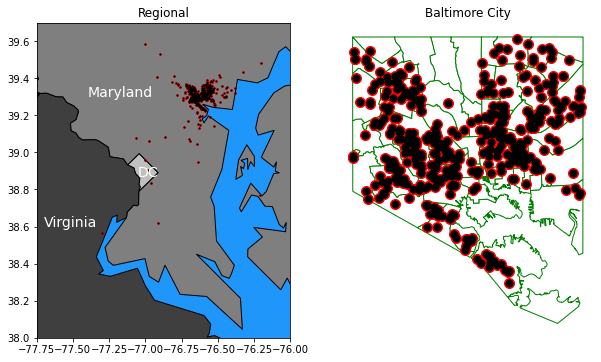

In [17]:
#Use US boundaries, focus on MD region
usa_gdf=gpd.read_file("USA_States_(Generalized).geojson")
usa_gdf["STATE_NAME"].unique()


states=['Delaware','Maryland','District of Columbia','Virginia', 'West Virginia']
dmv_gdf= usa_gdf[usa_gdf["STATE_NAME"].isin(states)]

#fisize=(6, 6)
rows=1
cols=2
#fig, ax= plt.subplots(rows, cols, figsize=figsize)
fig, ax= plt.subplots(rows, cols)
fig.set_size_inches(10,10)

#Map 1 - Big Picture 
cmap='binary'
dmv_gdf.plot("STATE_NAME", ax=ax[0], edgecolor="black", cmap=cmap)
ax[0].set_facecolor("#1e96fa")

#Zoom
outer_xlim= (-77.75, -76)
outer_ylim= (38, 39.7)
ax[0].set_xlim(outer_xlim)
ax[0].set_ylim(outer_ylim)

#State labels
md_label=(-77.4, 39.3)
va_label = (-77.7, 38.6)
dc_label = (-77.05, 38.87)
font_size=14
label_color="white"
ax[0].annotate("Maryland", color=label_color, xy=md_label, size=font_size)
ax[0].annotate("Virginia", color=label_color, xy=va_label, size=font_size)
ax[0].annotate("DC", color=label_color, xy=dc_label, size=font_size)

#Scatter of defs
ax[0].scatter(x=x_coords, y=y_coords, s=3, color="red")
ax[0].scatter(x=x_coords, y=y_coords, s=1, color="black")

#Turn off Lat/Long
#ax[0].set_axis_off()

#Map 2 - Big Picture 
turbo_gdf.plot(color="white", ax=ax[1], edgecolor="green")

#Scatter of defs
balt_defs= all_defs_df[all_defs_df["CSA"]!=False]
balt_x_coords = balt_defs["Long"].tolist()
balt_y_coords = balt_defs["Lat"].tolist()
ax[1].scatter(x=balt_x_coords, y=balt_y_coords, s=100, color="red")
ax[1].scatter(x=balt_x_coords, y=balt_y_coords, s=50, color="black")

ax[1].set(title="Baltimore City")
ax[1].set_axis_off()

ax[0].set(title="Regional")
#ax[0].set_axis_off() - #Keep lat + long, makes color work

In [18]:
#Functions to help visualize and analyze CSA data
def showCSA(csa):
    fig, ax = plt.subplots()
    turbo_gdf.plot(color="white", edgecolor="green", ax=ax)
    turbo_gdf[turbo_gdf.index==csa].plot(color="green", ax=ax)
    return True

def get_CSA_rank(csa, indicator):
    raw = turbo_gdf.loc[csa,indicator]
    rank = turbo_gdf[indicator].rank(ascending=False)[csa]
    return (raw,rank)

def get_All_CSA_ranks(csa):
    target_cols = list(turbo_gdf.columns)[1:]
    result_df=pd.DataFrame(index=target_cols, columns=["Indic", "Name", "Raw", "Rank"])
    for target in target_cols:
        raw, rank = get_CSA_rank(csa, target)
        #Hack
        name=target
        if name[0:-2] in api_shortname:
            name = api_shortname[name[0:-2]]
        
        result_df.loc[target]={"Indic":target, "Name":name, "Raw":raw, "Rank":rank}
    return result_df
        
def findName(name):
    
    #return all_defs_df[all_defs_df["Name"].str.contains(name, case=False)][["Name", "Race", "Outcome","CSA", "pretrial_rec", "asa_rec"]]
    return all_defs_df[all_defs_df["Psynym"].str.contains(name, case=False)][["Psynym", "Race", "Outcome","CSA", "pretrial_rec", "asa_rec"]]


# Part I Footnotes

### Footnote 29 - Defendant 215, Griffin

In [19]:
# Zoey Griffin
# Zoey Griffin's real name is used because this person tragically passed. Privacy issues are not the same
findName("Griffin")

,Psynym,Race,Outcome,CSA,pretrial_rec,asa_rec
215,Zoey Griffin,AA,HWOB,Westport/Mount Winans/Lakeland,HWOB,HWOB


In [20]:
dc_caseno_df[dc_caseno_df.def_index==215]

,def_index,dc_casenumber
249,215,4B02423005


True

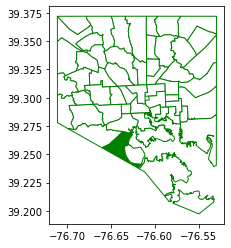

In [21]:
csa="Westport/Mount Winans/Lakeland"
showCSA(csa)

### Footnote 28 - The Westport/Mount Winans/Lakeland neighborhood ranks forty-first out of fifty-five in terms of median household income, making it one of the city’s poorer areas. . Its median household income in 2019 was approximately $36,000 per year.

In [22]:
#Look at Mr. Griffin's relative rankings
get_All_CSA_ranks(csa)

,Indic,Name,Raw,Rank
paa20,paa20,% Residents Black,51.585834,36.0
femhhs19,femhhs19,X% Female-Led Households w/ Children Under 18,72.687704,9.0
mhhi19,mhhi19,Median Household Income,35923.23874,41.0
hhpov19,hhpov19,% Family Households Below Poverty Line,24.046322,16.0
hhchpov19,hhchpov19,% Children Below Poverty Line,43.192272,13.0
ownroc20,ownroc20,% Housing Units Owner-Occupied,42.491864,38.0
vacant20,vacant20,% Residential Properties Vacant and Abandoned,7.391911,17.0
nohhint19,nohhint19,% Households w/ No Home Internet,25.120773,24.0
tanf19,tanf19,% Families Receiving TANF,7.728337,24.0
lifexp18,lifexp18,Life Expectancy,72.18519,27.0


In [23]:
#Median Household Income Ranks
turbo_gdf["mhhi19"].rank(ascending=False) 

CSA2010
Allendale/Irvington/S. Hilton            32.0
Beechfield/Ten Hills/West Hills          19.0
Belair-Edison                            26.0
Brooklyn/Curtis Bay/Hawkins Point        36.0
Canton                                    1.0
Cedonia/Frankford                        25.0
Cherry Hill                              51.0
Chinquapin Park/Belvedere                17.0
Claremont/Armistead                      42.0
Clifton-Berea                            44.0
Cross-Country/Cheswolde                  15.0
Dickeyville/Franklintown                 30.0
Dorchester/Ashburton                     24.0
Downtown/Seton Hill                      13.0
Edmondson Village                        31.0
Fells Point                               6.0
Forest Park/Walbrook                     29.0
Glen-Fallstaff                           35.0
Greater Charles Village/Barclay          27.0
Greater Govans                           34.0
Greater Mondawmin                        45.0
Greater Roland Park/Poplar

### Footnote 28 - By comparison, the city’s richest neighborhood by this measure (Canton) had a median income of $128,000.

In [24]:
get_All_CSA_ranks("Canton")

,Indic,Name,Raw,Rank
paa20,paa20,% Residents Black,3.908241,55.0
femhhs19,femhhs19,X% Female-Led Households w/ Children Under 18,15.022422,51.0
mhhi19,mhhi19,Median Household Income,128460.4821,1.0
hhpov19,hhpov19,% Family Households Below Poverty Line,2.216428,53.0
hhchpov19,hhchpov19,% Children Below Poverty Line,4.834254,51.0
ownroc20,ownroc20,% Housing Units Owner-Occupied,65.113974,18.0
vacant20,vacant20,% Residential Properties Vacant and Abandoned,0.396432,49.0
nohhint19,nohhint19,% Households w/ No Home Internet,6.382429,53.0
tanf19,tanf19,% Families Receiving TANF,0.363901,55.0
lifexp18,lifexp18,Life Expectancy,80.788522,5.0


True

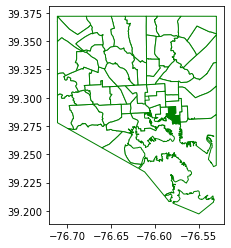

In [25]:
showCSA("Canton")

### Footnote 28: The poorest neighborhood by this measure (Upton/Druid Heights) had a median income of $21,000.

True

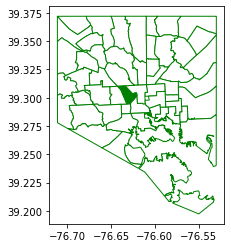

In [26]:
csa="Upton/Druid Heights"
showCSA(csa)

In [27]:
get_All_CSA_ranks(csa)

,Indic,Name,Raw,Rank
paa20,paa20,% Residents Black,88.021534,13.0
femhhs19,femhhs19,X% Female-Led Households w/ Children Under 18,84.354839,1.0
mhhi19,mhhi19,Median Household Income,21318.79696,55.0
hhpov19,hhpov19,% Family Households Below Poverty Line,41.685268,1.0
hhchpov19,hhchpov19,% Children Below Poverty Line,66.545718,1.0
ownroc20,ownroc20,% Housing Units Owner-Occupied,27.673546,50.0
vacant20,vacant20,% Residential Properties Vacant and Abandoned,27.016886,4.0
nohhint19,nohhint19,% Households w/ No Home Internet,31.595494,11.0
tanf19,tanf19,% Families Receiving TANF,17.577757,4.0
lifexp18,lifexp18,Life Expectancy,68.486106,45.0


### Footnote 30: Both ASA and Pretrial recommended HWOB

In [28]:
findName("Griffin")

,Psynym,Race,Outcome,CSA,pretrial_rec,asa_rec
215,Zoey Griffin,AA,HWOB,Westport/Mount Winans/Lakeland,HWOB,HWOB


<h1 style="text-align:center; color:black">Figure 2</h1>

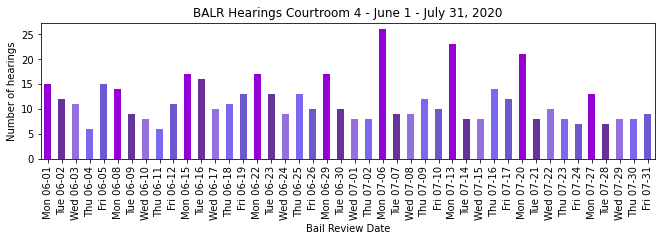

In [29]:
#THIS PRODUCES FIGURE 2 - HEARINGS OBSERVED

#Hearing Dates
fig, ax = plt.subplots()
fig.set_size_inches(11,2.5)
balr_df= all_defs_df.groupby('balr_date')

#Clean up labels and colors
color_dict={0:"darkviolet", 1:"rebeccapurple", 2:"mediumpurple", 3:"mediumslateblue", 4:"slateblue"}
xticks=[]
colors=[]
for x in list(balr_df.groups.keys()):
    #print(x.strftime('%a %m-%d'))
    xticks.append(x.strftime('%a %m-%d'))
    colors.append(color_dict[x.weekday()])

balr_df.size().plot.bar(ax=ax, color=colors, title="BALR Hearings Courtroom 4 - June 1 - July 31, 2020")
ax.set_ylabel("Number of hearings")
ax.set_xlabel("Bail Review Date")

ax.set_xticklabels(xticks)
pass #Just calling pass to stop the echoing of the xticks

### Footnote 68 - On average Judges heard nearly 12 bail review hearings a day

In [30]:
#Average number of hearings
print("Avg num hearings per day=", round(balr_df["balr_date"].count().mean(),2))

#Median number of hearings
print("Med num hearings per day=", round(balr_df["balr_date"].count().median(),2))

Avg num hearings per day= 11.57
Med num hearings per day= 10.0


<h1 style="text-align: center; color:black">Figure 3</h1>

In [31]:
#This creates Figure 3
a=all_defs_df["Outcome"].value_counts()
b=round(all_defs_df["Outcome"].value_counts(normalize=True)*100,1)

fig_df=pd.DataFrame(a)
fig_df["Pct"]=b.values

fig_df.to_clipboard()
fig_df

,Outcome,Pct
HWOB,313,61.5
UPB,85,16.7
ROR,71,13.9
MONEY,26,5.1
ROR-HDTN,14,2.8


<AxesSubplot:title={'center':'All Defendant Outcomes'}, ylabel='Outcome'>

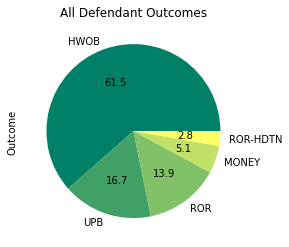

In [32]:
#At request of MD LR - Building a Pie Chart
a.plot.pie(title="All Defendant Outcomes",autopct="%.1f", cmap="summer")

### Footnote 72 - Surprisingly, when the prosecution made recommendations, it argued for detention 94% of the time

In [33]:
#Stats prosecution recommendations
pros_df = all_defs_df[all_defs_df["asa_rec"]!="-1"]
print("ASA made rec in ", len(pros_df), "cases")
fig_df = pd.DataFrame(pros_df["asa_rec"].value_counts())
fig_df["Pct"]=round(pros_df["asa_rec"].value_counts(normalize=True),2)
fig_df

ASA made rec in  480 cases


,asa_rec,Pct
HWOB,451,0.94
ROR,28,0.06
MONEY,1,0.00


### Footnote 73 - Pretrial services, meanwhile, recommended HWOB 75% of the time.

In [34]:
#Stats pretrial recommendations
pretrial_df = all_defs_df[all_defs_df["pretrial_rec"]!="-1"]
print("Pretrial made rec in ", len(pretrial_df), "cases")
fig_df = pd.DataFrame(pretrial_df["pretrial_rec"].value_counts())
fig_df["Pct"]=round(pretrial_df["pretrial_rec"].value_counts(normalize=True),2)
fig_df

Pretrial made rec in  500 cases


,pretrial_rec,Pct
HWOB,377,0.75
ROR,107,0.21
UPB,10,0.02
MONEY,6,0.01


### Footnote 74 - In the relatively few cases when the prosecution or pretrial services recommended ROR or UPB, judges usually rejected their recommendation

In [35]:
#Judges Following Pretrial Recs
for outcome, sub_df in pretrial_df.groupby("pretrial_rec"):
    n=len(sub_df)
    follow=len(sub_df[sub_df["Outcome"]==outcome])
    print(outcome, "followed in", follow,"of",n,"cases = ("+str(round(follow/n*100,2))+"%)")
    

HWOB followed in 299 of 377 cases = (79.31%)
MONEY followed in 3 of 6 cases = (50.0%)
ROR followed in 46 of 107 cases = (42.99%)
UPB followed in 4 of 10 cases = (40.0%)


In [36]:
#Judges Following ASA Recs
for outcome, sub_df in pros_df.groupby("asa_rec"):
    n=len(sub_df)
    follow=len(sub_df[sub_df["Outcome"]==outcome])
    print(outcome, "followed in", follow,"of",n,"cases = ("+str(round(follow/n*100,2))+"%)")
    

HWOB followed in 281 of 451 cases = (62.31%)
MONEY followed in 1 of 1 cases = (100.0%)
ROR followed in 8 of 28 cases = (28.57%)


<h1 style="text-align:center; color:black">Figure 4 - OLD</h1>

<AxesSubplot:title={'center':'Unk Outcomes (n=23)'}>

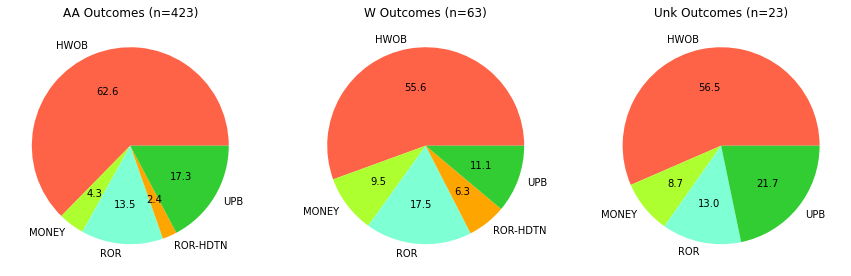

In [37]:
#Code to create figure 4
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

#List of cmaps https://matplotlib.org/stable/tutorials/colors/colormaps.html
std_colors=['tomato', 'greenyellow', 'aquamarine','orange','limegreen']
unk_colors=['tomato', 'greenyellow', 'aquamarine', 'limegreen']

#cmap="tab10"
fig.set_size_inches(15, 5)
all_defs_df[all_defs_df["Race"]=="AA"].groupby("Outcome").size().plot.pie(title="AA Outcomes (n=423)", label="", autopct="%.1f", ax=ax1, colors=std_colors)
all_defs_df[all_defs_df["Race"]=="W"].groupby("Outcome").size().plot.pie(title="W Outcomes (n=63)", label="", autopct="%.1f", ax=ax2, colors=std_colors)
all_defs_df[all_defs_df["Race"]=="Unk"].groupby("Outcome").size().plot.pie(title="Unk Outcomes (n=23)", label="", autopct="%.1f", ax=ax3, colors=unk_colors)

<h1 style="text-align:center; color:black">Figure 4 - NEW</h1>

<AxesSubplot:title={'center':'Unk Outcomes (n=23)'}>

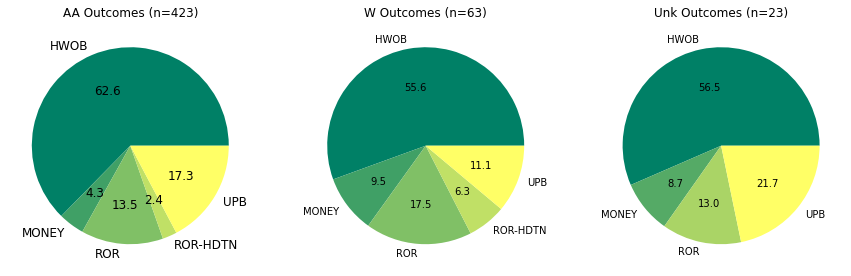

In [38]:
#UMLR Request to (a) use color-blind friendly colors; and (b) increase font size

#Code to create figure 4
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

#List of cmaps https://matplotlib.org/stable/tutorials/colors/colormaps.html
#Will need to figure how to solve unk problem
#std_colors=['tomato', 'greenyellow', 'aquamarine','orange','limegreen']
#unk_colors=['tomato', 'greenyellow', 'aquamarine', 'limegreen']


fig.set_size_inches(15, 5)
f4_aa=all_defs_df[all_defs_df["Race"]=="AA"].groupby("Outcome").size()
f4_w=all_defs_df[all_defs_df["Race"]=="W"].groupby("Outcome").size()
f4_uk=all_defs_df[all_defs_df["Race"]=="Unk"].groupby("Outcome").size()

cmap="summer"
f4_aa.plot.pie(title="AA Outcomes (n=423)", label="", autopct="%.1f", ax=ax1, 
               cmap=cmap, textprops={'fontsize': 12})
f4_w.plot.pie(title="W Outcomes (n=63)", label="", autopct="%.1f", ax=ax2, cmap=cmap)
f4_uk.plot.pie(title="Unk Outcomes (n=23)", label="", autopct="%.1f", ax=ax3, cmap=cmap)



### Code analyzing charges against defendants. Most of this analysis was not used in published article. Bonus content!

In [39]:
# load charges data charges
charges_df = pd.read_csv("dc_charges.csv")

In [40]:
#total charges
len(charges_df)

2554

In [41]:
def_series = pd.Series(charges_df["def_index"].unique())
for def_index, sub_df in charges_df.groupby("def_index"):
    def_series[def_index]=len(sub_df["casenumber"].unique())

    #Average number of charges per def = 
def_series.mean()

1.7509803921568627

In [42]:
#median number of charges per def
def_series.median()

1.0

In [43]:
#number of defs with more than one case
len(def_series[def_series>1])

63

In [44]:
#Just look at top charges
sub_df=charges_df[charges_df.charge_no==1]
len(sub_df)

605

In [45]:
#Peek under the hood
sub_df.head(2)

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
0,0,237,00503836B4,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,2 1313,BATTERY,CLOSED,TRIAL,NOT GUILTY,GUILTY,1994-07-18,NaN,NaN
3,3,404,0B02042236,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,2 0254,VIOLATE EXPARTE/PROT ORDER,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2021-02-04,NaN,NaN


In [46]:
len(sub_df.def_index.unique())

509

In [47]:
#number of unique charges
len(sub_df["charge_name"].unique())

101

### Now set-up for footnote 81 re "crimes of violence"

In [48]:
#Taken from statute -- MD Crim Law 14-101
crime_of_violence=set(["ASSAULT-FIRST DEGREE", "ATT 1ST DEG. MURDER", "ROBBERY", "ARMED ROBBERY",
                      "HOME INVASION", "FIREARM USE/FEL-VIOL CRIME", "FIREARM/DRUG TRAF CRIME",
                      "RAPE FIRST DEGREE", "ARSON/THREAT","ARSON - ATTEMPT", "ATT 2ND DEG. MURDER",
                      "CARJACKING", "KIDNAPPING", "ARMED CARJACKING", "MURDER - FIRST DEGREE"])

In [49]:
#Classify Assault 2

a2=set(['ASSAULT-SEC DEGREE'])

In [50]:
all_charges=set(sub_df["charge_name"].tolist())
non_viol=all_charges-crime_of_violence

print("Of",len(all_charges),"top charges,", len(non_viol),"are non-violent and",
      len(crime_of_violence),"are crimes of violence.")

Of 101 top charges, 86 are non-violent and 15 are crimes of violence.


In [51]:
#Count violent versus non-violent in a different way
#This will initially categorize assault 2 as NV
sub_df["charge_level"]=sub_df.charge_name.apply(lambda x: "V" if x in crime_of_violence else "NV")

/Users/colinstarger/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
#sub_df.columns
view_cols=['charge_name', 'charge_level']

In [53]:
#This will crunch to 509 defendants and Violent as top (first) charge
def_single_top = sub_df.sort_values(by="charge_level", ascending=False).groupby("def_index").first()
def_single_top[view_cols].head(10)

,charge_name,charge_level
def_index,,
0,FIREARM USE/FEL-VIOL CRIME,V
1,CDS: POSS W/I DIST: NARC,NV
2,ASSAULT-FIRST DEGREE,V
3,ASSAULT-SEC DEGREE,NV
4,DRIVING VEHICLE ON HIGHWAY WITHOUT REQUIRED LI...,NV
5,ASSAULT SEC DEG-LE/P&P/FIRE/EM,NV
6,DRIVING/ATTEMPTING DRIVE MOTOR VEH. ON HWY W/O...,NV
7,ROBBERY,V
8,CDS: POSS MARIJUANA 10 GM+,NV


### Footnote 81 - Using this statutory definition, only 28.9% of study defendants (147 of 509) faced a violent charge

In [54]:
#Basic count of violent v non violent
table= pd.DataFrame(def_single_top["charge_level"].value_counts())
table.columns=["Num"]
table["Pct"] = round(def_single_top["charge_level"].value_counts(normalize=True)*100,1)
table

,Num,Pct
NV,362,71.1
V,147,28.9


### Footnote 81 -- While 71.1% (362 of 509) defendants did not face a crime of violence charge, it should be noted that the close to half of these defendants (171) faced a Second Degree Assault charge.

In [55]:
#Count how many of top charges are assault 2
def_single_top.charge_name.value_counts()

ASSAULT-SEC DEGREE                                                                                  171
ASSAULT-FIRST DEGREE                                                                                 60
CDS: POSS W/I DIST: NARC                                                                             24
ROBBERY                                                                                              21
ATT 1ST DEG. MURDER                                                                                  20
                                                                                                   ... 
ILLEGAL POSS AMMO                                                                                     1
DRIVING, ATTEMPTING TO DRIVE MOTOR VEHICLE ON HIGHWAY WITHOUT REQUIRED LICENSE AND AUTHORIZATION      1
CON-ARMED ROBBERY                                                                                     1
DID CARRY A FIFLE,SHOTGUN 14IN                                  

### Footnote 81 -- The most common charge in Maryland, Second Degree Assault was also the most common top charge in our study (33.6%).In sum, 37.5% of study defendants (191 of 509) faced a non-violent top charge other than second degree assault

In [56]:
def mkPct(num,denom):
    return round(num/denom*100,1)

nv_no_assault2=362-171
assault2=171
v=147
denom=509

print("NV no assault 2 =", nv_no_assault2, "("+str(mkPct(nv_no_assault2,denom))+"%)")
print("Assault 2 =", assault2, "("+str(mkPct(assault2,denom))+"%)")
print("V =", v, "("+str(mkPct(v,denom))+"%)")



NV no assault 2 = 191 (37.5%)
Assault 2 = 171 (33.6%)
V = 147 (28.9%)


### Footnote 81 - Most Common Violent Charges

In [57]:
#violent top 5
v=def_single_top[def_single_top["charge_level"]=="V"]
table= pd.DataFrame(v["charge_name"].value_counts())
table.columns=["Num"]
table["Pct"] = round(v["charge_name"].value_counts(normalize=True)*100,2)
table.head(6)

,Num,Pct
ASSAULT-FIRST DEGREE,60,40.82
ROBBERY,21,14.29
ATT 1ST DEG. MURDER,20,13.61
MURDER - FIRST DEGREE,17,11.56
ARMED ROBBERY,7,4.76
FIREARM USE/FEL-VIOL CRIME,4,2.72


In [58]:
table.head(6).sum()

Num    129.00
Pct     87.76
dtype: float64

### Footnote 81 - Most common non-violent charges

In [59]:
#non violent top 10
criteria = (def_single_top["charge_level"]=="NV") & (def_single_top["charge_name"]!="ASSAULT-SEC DEGREE")
nv=def_single_top[criteria]
table= pd.DataFrame(nv["charge_name"].value_counts())
table.columns=["Num"]
table["Pct"] = round(nv["charge_name"].value_counts(normalize=True)*100,2)
table.head(10)

,Num,Pct
CDS: POSS W/I DIST: NARC,24,12.57
FIREARM POSS W/FEL CONVICT,15,7.85
REG FIREARM:ILLEGAL POSSESSION,13,6.81
VIOLATE PROT ORDER,10,5.24
LOADED HANDGUN ON PERSON,8,4.19
CDS DIST-NARC,8,4.19
HANDGUN ON PERSON,7,3.66
CDS-POSS OF FIREARMS,5,2.62
"THEFT: $100 TO UNDER $1,500",4,2.09
THEFT LESS THAN $100.00,4,2.09


## Now code to calculate percentages HWOB, etc based on Charge Type. Still footnote 81

In [60]:
merge_df=def_single_top[["charge_name", "charge_level"]].merge(all_defs_df, left_index=True, right_on="def_index")

In [61]:
pd.crosstab(merge_df.charge_level, merge_df.Outcome, margins=True)

Outcome,HWOB,MONEY,ROR,ROR-HDTN,UPB,All
charge_level,,,,,,
NV,199,19,60,9,75,362
V,114,7,11,5,10,147
All,313,26,71,14,85,509


In [62]:
#Outcome rates for violent crimes (77.6% HWOB)
merge_df[merge_df.charge_level=="V"].Outcome.value_counts(normalize=True)

HWOB        0.775510
ROR         0.074830
UPB         0.068027
MONEY       0.047619
ROR-HDTN    0.034014
Name: Outcome, dtype: float64

In [63]:
#Outcome rates for non-violent crimes (55% HWOB)
merge_df[merge_df.charge_level=="NV"].Outcome.value_counts(normalize=True)

HWOB        0.549724
UPB         0.207182
ROR         0.165746
MONEY       0.052486
ROR-HDTN    0.024862
Name: Outcome, dtype: float64

In [64]:
#Outcome rates second degree assault (40.9%)
merge_df[merge_df.charge_name=="ASSAULT-SEC DEGREE"].Outcome.value_counts(normalize=True)

HWOB        0.409357
UPB         0.315789
ROR         0.204678
MONEY       0.058480
ROR-HDTN    0.011696
Name: Outcome, dtype: float64

In [65]:
#Outcome rates for non assault2 non violent (67.5%)
merge_df[(merge_df.charge_level=="NV") & 
         (merge_df.charge_name!="ASSAULT-SEC DEGREE")].Outcome.value_counts(normalize=True)

HWOB        0.675393
ROR         0.130890
UPB         0.109948
MONEY       0.047120
ROR-HDTN    0.036649
Name: Outcome, dtype: float64

### Now Code finding defendants whose detention decisions seemed justified: FOOTNOTE 82

In [66]:
#Use Psuedonym
findName("Junes")

,Psynym,Race,Outcome,CSA,pretrial_rec,asa_rec
141,Thomas Junes,AA,HWOB,Lauraville,HWOB,HWOB
183,Antwan Junes,Unk,HWOB,Glen-Fallstaff,HWOB,HWOB


In [67]:
all_defs_df.loc[141]

def_index                       141
Psynym                 Thomas Junes
Race                             AA
balr_date       2020-06-17 00:00:00
judge_name                    Owens
Outcome                        HWOB
pretrial_rec                   HWOB
asa_rec                        HWOB
Long                     -76.574673
Lat                        39.34888
CSA                      Lauraville
Name: 141, dtype: object

In [68]:
#Junes charges
charges_df[charges_df.def_index==141]

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
1361,1362,141,3B02422927,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,1 0990,MURDER - FIRST DEGREE,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1362,1363,141,3B02422927,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,1 1107,MURDER-SECOND DEGREE,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1363,1364,141,3B02422927,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,3,1 1420,ASSAULT-FIRST DEGREE,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1364,1365,141,3B02422927,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,4,1 1415,ASSAULT-SEC DEGREE,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1365,1366,141,3B02422927,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,5,1 5299,FIREARM USE/FEL-VIOL CRIME,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1366,1367,141,3B02422927,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,6,1 5212,HANDGUN ON PERSON,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN


In [69]:
#Travell Pelliam
findName("Pelliam")

,Psynym,Race,Outcome,CSA,pretrial_rec,asa_rec
168,Travell Pelliam,AA,HWOB,Southeastern,HWOB,HWOB


In [70]:
#Pelliam BALR info
all_defs_df.loc[168]

def_index                       168
Psynym              Travell Pelliam
Race                             AA
balr_date       2020-06-19 00:00:00
judge_name                    Smith
Outcome                        HWOB
pretrial_rec                   HWOB
asa_rec                        HWOB
Long                      -76.54337
Lat                       39.278917
CSA                    Southeastern
Name: 168, dtype: object

In [71]:
#Pelliam chages
charges_df[charges_df.def_index==168]

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
1463,1464,168,4B02416782,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,2 0705,ARMED ROBBERY,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1464,1465,168,4B02416782,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,2 0700,ROBBERY,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1465,1466,168,4B02416782,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,3,1 1420,ASSAULT-FIRST DEGREE,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1466,1467,168,4B02416782,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,4,1 1415,ASSAULT-SEC DEGREE,CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1467,1468,168,4B02416782,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,5,1A1137,"ATT-THEFT: $100 TO UND $1,500",CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN
1468,1469,168,4B02416782,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,6,1A1136,"ATT-THEFT: $1,500 TO UND $25K",CLOSED,FORWARDED TO CIRCUIT COURT,NaN,NaN,NaN,NaN,NaN


In [72]:
#Nigel Ingaglia 
findName("Ingaglia")

,Psynym,Race,Outcome,CSA,pretrial_rec,asa_rec
413,Nigel Ingaglia,AA,HWOB,Southern Park Heights,HWOB,HWOB
487,Bruce Ingaglia,AA,HWOB,The Waverlies,HWOB,HWOB


In [73]:
#Hyman balr
all_defs_df.loc[413]

def_index                         413
Psynym                 Nigel Ingaglia
Race                               AA
balr_date         2020-07-20 00:00:00
judge_name                     Scurti
Outcome                          HWOB
pretrial_rec                     HWOB
asa_rec                          HWOB
Long                        -76.66179
Lat                         39.334049
CSA             Southern Park Heights
Name: 413, dtype: object

In [74]:
#Hyman charges
charges_df[charges_df.def_index==413]

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
175,175,413,0B02420719,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,2 0480,MOTOR VEH/UNLAWFUL TAKING,CLOSED,JURY TRIAL PRAYED,NaN,NaN,NaN,NaN,NaN
176,176,413,0B02420719,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,1 1136,"THEFT: $1,500 TO UNDER $25,000",CLOSED,JURY TRIAL PRAYED,NaN,NaN,NaN,NaN,NaN
177,177,413,0B02420719,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,3,1 1466,UNAUTH REMOVAL OF MV,CLOSED,JURY TRIAL PRAYED,NaN,NaN,NaN,NaN,NaN
447,447,413,1B02420125,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,1 1420,ASSAULT-FIRST DEGREE,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-11-18,2021-03-23,NaN
448,448,413,1B02420125,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,1 1415,ASSAULT-SEC DEGREE,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2021-03-23,2021-03-23,NaN
449,449,413,1B02420125,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,3,1 1425,RECKLESS ENDANGERMENT,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2021-03-23,2021-03-23,NaN
450,450,413,1B02420125,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,4,1 5200,DANGEROUS WEAPON-INT/INJURE,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2021-03-23,2021-03-23,NaN
566,566,413,1B02423590,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,1 1415,ASSAULT-SEC DEGREE,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-08-21,NaN,NaN
850,851,413,2B02422828,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,1 1415,ASSAULT-SEC DEGREE,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-09-14,NaN,NaN
851,852,413,2B02422828,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,2 0254,VIOLATE PROT ORDER,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-09-14,NaN,NaN


In [75]:
### Now code pulling data for individuals highlighted -- Tellman

In [76]:
#Alvis Tellman 
findName("Tellman")

,Psynym,Race,Outcome,CSA,pretrial_rec,asa_rec
85,Alvis Tellman,AA,HWOB,Howard Park/West Arlington,HWOB,HWOB


In [77]:
charges_df[charges_df.def_index==85]

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
98,98,85,0B02419018,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,1 1416,ASSAULT SEC DEG-LE/P&P/FIRE/EM,CLOSED,JURY TRIAL PRAYED,NaN,NaN,NaN,NaN,NaN
99,99,85,0B02419018,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,1 1415,ASSAULT-SEC DEGREE,CLOSED,JURY TRIAL PRAYED,NaN,NaN,NaN,NaN,NaN
100,100,85,0B02419018,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,3,1 1415,ASSAULT-SEC DEGREE,CLOSED,JURY TRIAL PRAYED,NaN,NaN,NaN,NaN,NaN
101,101,85,0B02419018,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,4,1 0600,RESIST/INTERFERE WITH ARREST,CLOSED,JURY TRIAL PRAYED,NaN,NaN,NaN,NaN,NaN


### Footnote 83 - Mr. Tellman was from the “Howard Park/West Arlington” neighborhood. This neighborhood is 89% Black and ranks 21 out of 55 in median household income ($53,5341 in 2019

True

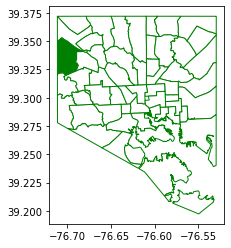

In [78]:
csa="Howard Park/West Arlington"
showCSA(csa)

In [79]:
get_All_CSA_ranks(csa)

,Indic,Name,Raw,Rank
paa20,paa20,% Residents Black,89.494993,11.0
femhhs19,femhhs19,X% Female-Led Households w/ Children Under 18,42.238648,37.0
mhhi19,mhhi19,Median Household Income,53534.12931,21.0
hhpov19,hhpov19,% Family Households Below Poverty Line,13.321251,30.0
hhchpov19,hhchpov19,% Children Below Poverty Line,18.68071,33.0
ownroc20,ownroc20,% Housing Units Owner-Occupied,68.467896,15.0
vacant20,vacant20,% Residential Properties Vacant and Abandoned,1.748252,31.0
nohhint19,nohhint19,% Households w/ No Home Internet,28.285714,14.0
tanf19,tanf19,% Families Receiving TANF,3.800384,41.0
lifexp18,lifexp18,Life Expectancy,74.739491,16.0


### More defendant stories SCUTT - footnote 93

In [80]:
#Kevin Scutt 
findName("scutt")

,Psynym,Race,Outcome,CSA,pretrial_rec,asa_rec
328,Kevin Scutt,AA,HWOB,False,HWOB,HWOB


In [81]:
charges_df[charges_df.def_index==328]

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
1580,1581,328,4B02420541,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,1 5212,HANDGUN ON PERSON,DEFERRED PAYMENT,TRIAL,OTHER PLEA,STET,2020-09-11,NaN,NaN
1581,1582,328,4B02420541,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,1 1455,LOADED HANDGUN ON PERSON,DEFERRED PAYMENT,TRIAL,OTHER PLEA,STET,2020-09-11,NaN,NaN
1582,1583,328,4B02420541,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,3,1 0175,HANDGUN IN VEHICLE,DEFERRED PAYMENT,TRIAL,OTHER PLEA,STET,2020-09-11,NaN,NaN
1583,1584,328,4B02420541,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,4,1 1454,LOADED HANDGUN IN VEHICLE,DEFERRED PAYMENT,TRIAL,GUILTY,GUILTY,2020-09-11,NaN,NaN
1584,1585,328,4B02420541,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,5,1 5285,POSS OF FIREARM MINOR,DEFERRED PAYMENT,TRIAL,OTHER PLEA,STET,2020-09-11,NaN,NaN
1585,1586,328,4B02420541,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,6,NaN,HANDGUN WITHIN 100YDS OF PARKS,DEFERRED PAYMENT,TRIAL,OTHER PLEA,STET,2020-09-11,NaN,NaN
1586,1587,328,4B02420541,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,7,NaN,HANDGUN IN VEH. WITHIN 100YDS,DEFERRED PAYMENT,TRIAL,OTHER PLEA,STET,2020-09-11,NaN,NaN


### EPPURSON -- Footnote 97

In [82]:
#Andre Eppurson
findName("eppurson")

,Psynym,Race,Outcome,CSA,pretrial_rec,asa_rec
433,Andre Eppurson,AA,HWOB,Lauraville,HWOB,HWOB


In [83]:
charges_df[charges_df.def_index==433]

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
456,456,433,1B02420286,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,1 0439,RFL/SHOTGN POSS-DISQUAL,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-09-02,NaN,NaN
457,457,433,1B02420286,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,1 1285,ILLEGAL POSS AMMO,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-09-02,NaN,NaN
458,458,433,1B02420286,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,3,NaN,CARRY A RIFLE IN BALT CITY,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-09-02,NaN,NaN


### Footnote 97 -- Mr. Eppurson hailed from Lauraville, in the Northeastern part of Baltimore. This is a more middle-class neighborhood with a median household income of approximately $75k

True

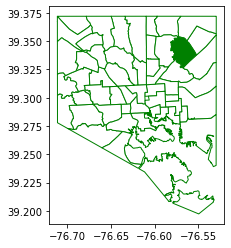

In [84]:
csa="Lauraville"
showCSA(csa)

In [85]:
get_All_CSA_ranks(csa)

,Indic,Name,Raw,Rank
paa20,paa20,% Residents Black,59.316496,31.0
femhhs19,femhhs19,X% Female-Led Households w/ Children Under 18,36.666667,40.0
mhhi19,mhhi19,Median Household Income,74759.45823,9.0
hhpov19,hhpov19,% Family Households Below Poverty Line,6.004213,44.0
hhchpov19,hhchpov19,% Children Below Poverty Line,13.777219,39.0
ownroc20,ownroc20,% Housing Units Owner-Occupied,71.332285,11.0
vacant20,vacant20,% Residential Properties Vacant and Abandoned,1.213211,33.0
nohhint19,nohhint19,% Households w/ No Home Internet,8.767185,48.0
tanf19,tanf19,% Families Receiving TANF,4.163799,38.0
lifexp18,lifexp18,Life Expectancy,74.693887,17.0


### Code to calculate individual judge detention rates

In [86]:
# All judges - Raw
judges= all_defs_df.judge_name.unique()
columns = all_defs_df.Outcome.unique()
result_df=pd.DataFrame(index=judges, columns=columns)

for judge, sub_df in all_defs_df.groupby("judge_name"):
    result_row=sub_df["Outcome"].value_counts()
    result_df.loc[judge]=result_row
result_df.loc["SUM"]=result_df.sum(axis=0)
result_df=result_df.fillna("-")
result_df

,UPB,HWOB,ROR,MONEY,ROR-HDTN
Boles,9,13.0,1,1,1
Dunn,-,33.0,-,8.0,-
Studdard,-,40.0,19.0,2.0,1.0
Chen,14.0,39.0,-,-,-
Green,-,8.0,7.0,-,-
Baylor-Thompson,2,33.0,23,5,8
Smith,6.0,23.0,-,-,-
Scurti,32.0,32.0,-,2.0,3.0
Dorsey,-,24.0,9.0,2.0,-
Owens,11.0,19.0,4.0,-,-


### Footnote 99 - Judge Baylor-Thompson's detention rate of 46.5% was the second lowest among the 16 Baltimore City District Court judges... Judge Scurti had the lowest detention rate – 46.4% The average detention rate for judges who presided at bail hearings of presumptively innocent defendants was 66% and the median 64.5%

In [87]:
# All judges - Percentages
judges= all_defs_df.judge_name.unique()
columns = all_defs_df.Outcome.unique()
result_df=pd.DataFrame(index=judges, columns=columns)

for judge, sub_df in all_defs_df.groupby("judge_name"):
    result_row=round(sub_df["Outcome"].value_counts(normalize=True)*100,2)
    result_df.loc[judge]=result_row

result_df= result_df.sort_values(by="HWOB", ascending=False)
result_df.loc["AVG"]=result_df.mean(axis=0)
result_df.loc["MED"]=result_df.median(axis=0)
result_df=result_df.fillna("-")
result_df

,UPB,HWOB,ROR,MONEY,ROR-HDTN
Kerry,-,100.000000,-,-,-
Dunn,-,80.490000,-,19.51,-
Smith,20.69,79.310000,-,-,-
Pastore,-,77.780000,11.11,-,11.11
Hengrer,15.38,76.920000,7.69,-,-
Chen,26.42,73.580000,-,-,-
Dorsey,-,68.570000,25.71,5.71,-
Studdard,-,64.520000,30.65,3.23,1.61
Etheridge,37.5,62.500000,-,-,-
Greene,26.09,60.870000,13.04,-,-


### Footnote 102 - All the time he spent in jail based on the mere accusation of gun possession – 43 days 

In [88]:
#Eppurson days in jail

release = date(2020, 9, 2)
balr = date(2020, 7, 21)
delta = release-balr
delta.days

43

### Set up for Judge Dunn

### Footnote 105 - Among the 41 defendants whose bail reviews he conducted, Judge Dunn never released a single person on recognizance, unsecured bond or home detention.  The judge ordered money bail for eight detainees.

In [89]:
#Judge Dunn Release Stats
all_defs_df[all_defs_df.judge_name.str.contains("Dunn")]["Outcome"].value_counts()

HWOB     33
MONEY     8
Name: Outcome, dtype: int64

In [90]:
#Judge Dunn Release Stats
all_defs_df[all_defs_df.judge_name.str.contains("Dunn")]["Outcome"].value_counts(normalize=True)

HWOB     0.804878
MONEY    0.195122
Name: Outcome, dtype: float64

### Footnote 107 - Dunn dates

In [91]:
#Judge Dunn Dates
all_defs_df[all_defs_df.judge_name.str.contains("Dunn")]["balr_date"].unique()

array(['2020-06-02T00:00:00.000000000', '2020-06-11T00:00:00.000000000',
       '2020-07-16T00:00:00.000000000', '2020-07-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [92]:
#Number of Judges
len(all_defs_df["judge_name"].unique())

16

In [93]:
#Judge Smith
all_defs_df[all_defs_df["judge_name"]=="Smith"]["Outcome"].value_counts()

HWOB    23
UPB      6
Name: Outcome, dtype: int64

### Footnote 110

In [ ]:
#Judge Smith
all_defs_df[all_defs_df["judge_name"]=="Smith"]["Outcome"].value_counts(normalize=True)

### Footnote 112 - Judicial detention rates (calculated above - just echoing variable)

In [ ]:
result_df

<h1 style="text-align:center; color:black">Figure 5</h1>

In [94]:
#Read DPSCS data
jail_df = pd.read_excel("Jail Data.xlsx", sheet_name="Data")

#Echo first 5 rows
jail_df.head(5)

,County,Date,Year,Intakes,Departures,Last Day Count,Average Daily Population,Pretrial (1-90 days),Pretrial (91+ days),PSI,...,Home detention (average),Weekend (average),Commitments,Suicides,Walkoff,Escapes,Pretrial (total),Sentenced (total),Total Jail Population,Unnamed: 30
0,Allegany,2014-01-01,2014,134.0,129,161.0,150.0,52,29,1,...,8.0,11.0,0,0,0,0.0,81,71,152,Row Labels
1,Anne Arundel,2014-01-01,2014,722.0,722,779.0,803.0,313,114,0,...,56.0,94.0,2,0,0,0.0,427,346,773,NaN
2,Baltimore,2014-01-01,2014,1265.0,1182,1433.0,1366.0,639,200,33,...,34.0,61.0,4,0,0,0.0,839,539,1378,NaN
3,Baltimore City,2014-01-01,2014,2324.0,2304,3686.0,3713.0,1646,1487,84,...,24.0,64.0,18,0,0,0.0,3133,0,3133,NaN
4,Calvert,2014-01-01,2014,446.0,415,329.0,291.0,73,49,3,...,3.0,25.0,0,0,0,0.0,122,180,302,NaN


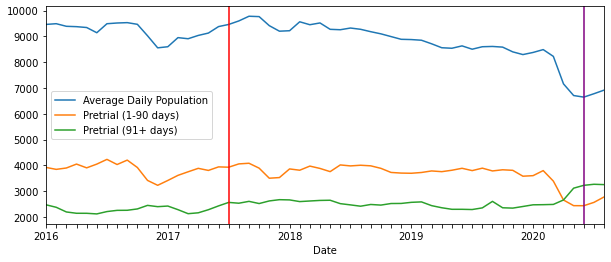

In [95]:
#FIGURE 5
f= jail_df.query("Date.dt.year >= 2016").groupby("Date").sum()[["Average Daily Population", "Pretrial (1-90 days)", "Pretrial (91+ days)"]]
n = f.index.strftime("%Y %m").to_list()

fig, ax = plt.subplots()

f.plot(figsize=(10,4), xticks=n, ax=ax)

ax.axvline(dt.datetime(2017, 7, 1), color="red")
ax.axvline(dt.datetime(2020, 6, 1), color="purple")

### Footnote 147: initial defendant population (83% Black, 12%white)

In [97]:
all_defs_df.Race.value_counts(normalize=True)

AA     0.831041
W      0.123772
Unk    0.045187
Name: Race, dtype: float64

### Footnote 147: 63% Black HWOB v 55% white HWOB

In [98]:
all_defs_df[all_defs_df.Race=="AA"].Outcome.value_counts(normalize=True)

HWOB        0.626478
UPB         0.172577
ROR         0.134752
MONEY       0.042553
ROR-HDTN    0.023641
Name: Outcome, dtype: float64

In [99]:
all_defs_df[all_defs_df.Race=="W"].Outcome.value_counts(normalize=True)

HWOB        0.555556
ROR         0.174603
UPB         0.111111
MONEY       0.095238
ROR-HDTN    0.063492
Name: Outcome, dtype: float64

### Footnote 148 -- Because Black people were arrested and detained at higher rates, this resulted in 85% of all people held without bail being Black. Only 11% of those suffering pretrial detention were white.

In [100]:
# Get numbers and percentages for HWOB
hwob_df=all_defs_df[all_defs_df.Outcome=="HWOB"]
print(len(hwob_df))
hwob_df.Race.value_counts(normalize=True)

313


AA     0.846645
W      0.111821
Unk    0.041534
Name: Race, dtype: float64

<h1 style="text-align:center; color:black">Figure 6</h1>

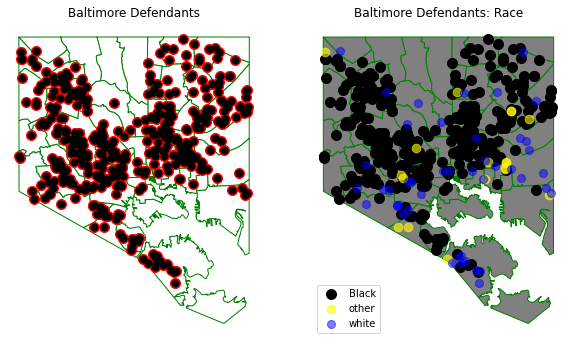

In [101]:

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)

#All Defendants
turbo_gdf.plot(color="white", ax=ax[0], edgecolor="green")
ax[0].scatter(x=balt_x_coords, y=balt_y_coords, s=100, color="red")
ax[0].scatter(x=balt_x_coords, y=balt_y_coords, s=50, color="black")
ax[0].set(title="Baltimore Defendants")
ax[0].set_axis_off()


#Define cohorts for mapping
aa_x_coords = balt_defs[balt_defs.Race=="AA"]["Long"].tolist()
aa_y_coords = balt_defs[balt_defs.Race=="AA"]["Lat"].tolist()
ww_x_coords = balt_defs[balt_defs.Race=="W"]["Long"].tolist()
ww_y_coords = balt_defs[balt_defs.Race=="W"]["Lat"].tolist()
unk_x_coords = balt_defs[balt_defs.Race=="Unk"]["Long"].tolist()
unk_y_coords = balt_defs[balt_defs.Race=="Unk"]["Lat"].tolist()
hwob_x_coords = balt_defs[balt_defs.Outcome=="HWOB"]["Long"].tolist()
hwob_y_coords = balt_defs[balt_defs.Outcome=="HWOB"]["Lat"].tolist()

#Defendants by race
turbo_gdf.plot(color="gray", ax=ax[1], edgecolor="green")

ax[1].scatter(x=aa_x_coords, y=aa_y_coords, s=100, color="black", label="Black")
ax[1].scatter(x=unk_x_coords, y=unk_y_coords, s=75, color="yellow", alpha=.6, label="other")
ax[1].scatter(x=ww_x_coords, y=ww_y_coords, s=65, color="blue", alpha=.5, label="white")

ax[1].set(title="Baltimore Defendants: Race")
ax[1].legend()
ax[1].set_axis_off()



### Footnote 150 - Of the 509 defendants in the study, 429 had Baltimore City addresses (83%)

In [102]:
#Baltimore defendants
len(balt_defs)

425

In [103]:
# % of all defendants
425/509

0.8349705304518664

### Footnote 150 - The racial breakdown is similar to the larger study – 85% Black (362), 11% white (45) and 4% other (18)

In [104]:
balt_defs.Race.value_counts()

AA     362
W       45
Unk     18
Name: Race, dtype: int64

In [105]:
balt_defs.Race.value_counts(normalize=True)

AA     0.851765
W      0.105882
Unk    0.042353
Name: Race, dtype: float64

In [106]:
balt_defs[balt_defs.Race=="AA"].Outcome.value_counts(normalize=True)

HWOB        0.616022
UPB         0.174033
ROR         0.143646
MONEY       0.038674
ROR-HDTN    0.027624
Name: Outcome, dtype: float64

In [107]:
balt_defs[balt_defs.Race=="W"].Outcome.value_counts(normalize=True)

HWOB        0.600000
ROR         0.133333
UPB         0.111111
MONEY       0.088889
ROR-HDTN    0.066667
Name: Outcome, dtype: float64

In [108]:
balt_defs[balt_defs.Race=="Unk"].Outcome.value_counts(normalize=True)

HWOB     0.555556
UPB      0.222222
ROR      0.166667
MONEY    0.055556
Name: Outcome, dtype: float64

### Now we start getting heavier into BNIA visualizations

<h1 style="text-align: center; color:black">Figure 7</h1>

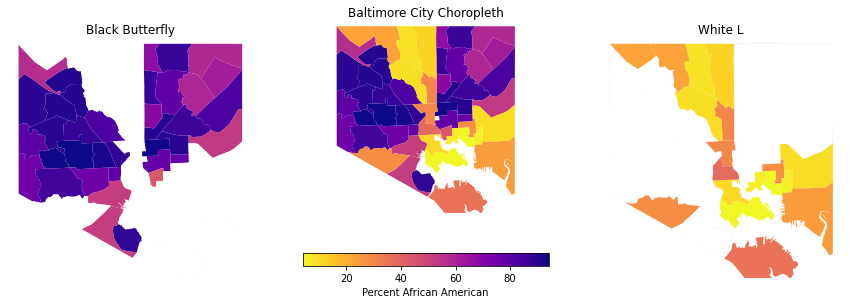

In [109]:
#Draw black butterfly and white L
target="paa20"
fig_rows=1
fig_cols=3
figsize=(fig_cols*5,fig_rows*5)
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=figsize)

default_ylim=(39.225, 39.375)
a=1
b=0
c=2

#This is center map. Uses default, which is to show everything
createCSA_Chloro(axs[a], target)
axs[a].set_ylim(default_ylim) 
axs[a].set_axis_off()
axs[a].set_title("Baltimore City Choropleth")

#This creates Black butterfly
num_show=37
createCSA_Chloro(axs[b], target, num_show)
axs[b].set_ylim(default_ylim) #Kludge from cell above
axs[b].set_axis_off()
axs[b].set_title("Black Butterfly")

#This is the reverse (white L). Note call to Chloro last var TRUE
num_show=18
createCSA_Chloro(axs[c], target, num_show, True)
axs[c].set_ylim(default_ylim)
axs[c].set_axis_off()
axs[c].set_title("White L")

vmax=turbo_gdf[target].max()
vmin=turbo_gdf[target].min()
# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='plasma_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm, orientation="horizontal", ax=axs[a], label="Percent African American")


In [110]:
#Get Min/Max percentages
paa_min=turbo_gdf["paa20"].min()
min_hood = turbo_gdf[turbo_gdf.paa20==paa_min].index[0]

paa_max=turbo_gdf["paa20"].max()
max_hood = turbo_gdf[turbo_gdf.paa20==paa_max].index[0]

print("Min=", paa_min, min_hood,"  Max=",paa_max, max_hood)


Min= 3.908241291 Canton   Max= 94.17179946 Greater Rosemont


In [111]:
#make a generic function for the three mao

def makeTripleChloro(target, target_title):
    fig_rows=1
    fig_cols=3
    figsize=(fig_cols*5,fig_rows*5)
    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=figsize)

    default_ylim=(39.225, 39.375)
    a=1
    b=0
    c=2

    #This is center map. Uses default, which is to show everything
    createCSA_Chloro(axs[a], target)
    axs[a].set_ylim(default_ylim) 
    axs[a].set_axis_off()
    axs[a].set_title(target_title)

    #This is left map ()
    num_show=37
    createCSA_Chloro(axs[b], target, num_show)
    axs[b].set_ylim(default_ylim) #Kludge from cell above
    axs[b].set_axis_off()
    #axs[b].set_title("Black Butterfly")

    #This is the reverse (white L). Note call to Chloro last var TRUE
    num_show=18
    createCSA_Chloro(axs[c], target, num_show, True)
    axs[c].set_ylim(default_ylim)
    axs[c].set_axis_off()
    #axs[c].set_title("White L")

    vmax=turbo_gdf[target].max()
    vmin=turbo_gdf[target].min()
    # Create colorbar legend
    cmap="plasma_r"
    if getAscend(target):
        cmap="plasma"
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
    # add the colorbar to the figure
    #fig.colorbar(sm, orientation="horizontal", ax=axs[a], label="Percent African American")
    fig.colorbar(sm, orientation="horizontal", ax=axs[a])
    
    return True


In [116]:
#make function that creates triple but on AX passed in, with labels
#Then scatter on top
# From stories

def makeButterfly_el(axs, target, target_title):
    default_ylim=(39.225, 39.375)
    a=1
    b=0
    c=2

    #This is center map. Uses default, which is to show everything
    createCSA_Chloro(axs[a], target)
    axs[a].set_ylim(default_ylim) 
    axs[a].set_axis_off()
    axs[a].set_title(target_title)

    #This is left map ()
    num_show=37
    createCSA_Chloro(axs[b], target, num_show)
    axs[b].set_ylim(default_ylim) #Kludge from cell above
    axs[b].set_axis_off()
    #axs[b].set_title("Black Butterfly")

    #This is the reverse (white L). Note call to Chloro last var TRUE
    num_show=18
    createCSA_Chloro(axs[c], target, num_show, True)
    axs[c].set_ylim(default_ylim)
    axs[c].set_axis_off()
    #axs[c].set_title("White L")

    vmax=turbo_gdf[target].max()
    vmin=turbo_gdf[target].min()
    # Create colorbar legend
    cmap="plasma_r"
    if getAscend(target):
        cmap="plasma"
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
    # add the colorbar to the figure
    #fig.colorbar(sm, orientation="horizontal", ax=axs[a], label="Percent African American")
    fig.colorbar(sm, orientation="horizontal", ax=axs[a])

    return True

In [112]:
# One by One -- Turn into a function
# Vary on what to plot on top ALL, BLACK or HWOB
# Then indicator

def scatterIndicator(indicator, use_x_coords = balt_x_coords, use_y_coords= balt_y_coords, scatter_color="black", scatter_size=15):
    
    title=api_shortname[indicator[:-2]]

    fig_rows=1
    fig_cols=3
    figsize=(fig_cols*5,fig_rows*5)
    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=figsize)
    makeButterfly_el(axs, indicator, title)

    axs[0].scatter(x=use_x_coords, y=use_y_coords, s=scatter_size, color=scatter_color)
    #axs[1].scatter(x=use_x_coords, y=use_y_coords, s=scatter_size, color=scatter_color)
    axs[2].scatter(x=use_x_coords, y=use_y_coords, s=scatter_size, color=scatter_color)
    return axs



### Footnote 161 - correlation coefficient between all_defs and PAA = 62%

In [114]:
# Correlations for all defs
by="all_defs"
turbo_gdf.corr().sort_values(by=by, ascending=False, key=abs)[by] #Not sure why this is throwing an error

all_defs      1.000000
black_defs    0.954851
hwob_defs     0.918589
lifexp18     -0.654898
pubtran19     0.620734
paa20         0.619235
nohhint19     0.609382
voted18      -0.603228
tanf19        0.583968
vacant20      0.578045
mhhi19       -0.566499
femhhs19      0.566019
hhchpov19     0.540131
lesshs19      0.536252
hhpov19       0.534428
novhcl19      0.533766
nilf19        0.513006
abshs19       0.433862
ownroc20     -0.432155
white_defs    0.248757
Name: all_defs, dtype: float64

<h1 style="text-align: center; color:black">Figure 8</h1>

Text(0.5, 1.0, 'Distribution of all Defendants')

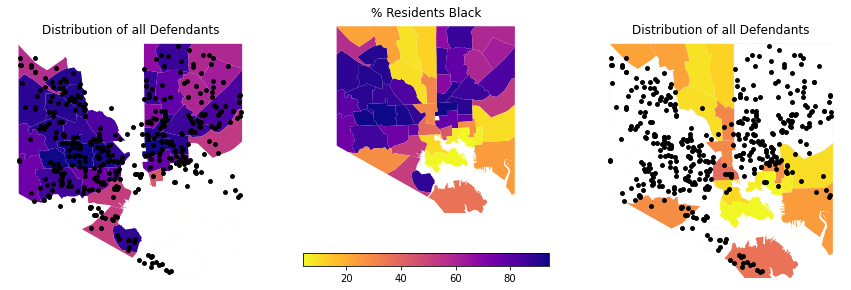

In [117]:
axs = scatterIndicator("paa20")
subtitle="Distribution of all Defendants"
axs[0].set_title(subtitle)
axs[2].set_title(subtitle)

### Footnote 164 - coefficient for only black defendants and PAA = .73

In [118]:
by="black_defs"
turbo_gdf.corr().sort_values(by=by, ascending=False, key=abs)[by]

black_defs    1.000000
all_defs      0.954851
hwob_defs     0.884695
paa20         0.728205
pubtran19     0.664633
lifexp18     -0.637139
femhhs19      0.617603
vacant20      0.610023
tanf19        0.601804
nohhint19     0.597981
mhhi19       -0.564304
novhcl19      0.558330
hhchpov19     0.536868
nilf19        0.533890
hhpov19       0.526104
voted18      -0.525811
lesshs19      0.429468
ownroc20     -0.422404
abshs19       0.377152
white_defs   -0.026644
Name: black_defs, dtype: float64

<h1 style="text-align: center; color:black">Figure 9</h1>

Text(0.5, 1.0, 'Distribution of Black Defendants')

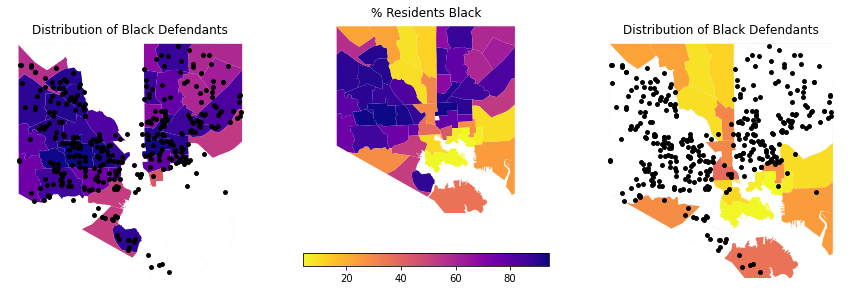

In [119]:
axs = scatterIndicator("paa20", aa_x_coords, aa_y_coords)
subtitle="Distribution of Black Defendants"
axs[0].set_title(subtitle)
axs[2].set_title(subtitle)

## Now set up for Part III - DNA of Structural Racism in Baltimore

In [120]:
len(aa_x_coords)

362

In [121]:
def getMaxMinInfo(indicator):

    #Get Min/Max percentages
    paa_min=turbo_gdf[indicator].min()
    min_hood = turbo_gdf[turbo_gdf[indicator]==paa_min].index[0]

    paa_max=turbo_gdf[indicator].max()
    max_hood = turbo_gdf[turbo_gdf[indicator]==paa_max].index[0]

    print("Min=", paa_min, min_hood,"  Max=",paa_max, max_hood)
    return True

In [122]:
#Sub DF of stories
stories=[67,82,85,179,213,214,215,267,328,353,433]
story_cols= ["def_index", "Psynym", "Race", "balr_date", "judge_name", "Outcome", "Long", "Lat"]
stories_df=all_defs_df.loc[stories, story_cols].reset_index()
stories_df["CSA"]=stories_df.apply(pullCSA, axis=1)
stories_df

,index,def_index,Psynym,Race,balr_date,judge_name,Outcome,Long,Lat,CSA
0,67,67,Garrett Rabinson,W,2020-06-08,Baylor-Thompson,HWOB,-76.636253,39.331592,Medfield/Hampden/Woodberry/Remington
1,82,82,Dionicio Wordrick,AA,2020-06-10,Smith,HWOB,-76.617872,39.295866,Midtown
2,85,85,Alvis Tellman,AA,2020-06-10,Smith,HWOB,-76.705735,39.332378,Howard Park/West Arlington
3,179,179,Terrence Mirgan,W,2020-06-22,Chen,HWOB,-76.697767,39.363339,Cross-Country/Cheswolde
4,213,213,Kawante Menroe,W,2020-06-25,Chen,HWOB,-76.900626,39.529756,False
5,214,214,Derrick Pewell,AA,2020-06-25,Chen,HWOB,-76.593350,39.358102,Loch Raven
6,215,215,Zoey Griffin,AA,2020-06-25,Chen,HWOB,-76.643680,39.262914,Westport/Mount Winans/Lakeland
7,267,267,HERBERT Smath,AA,2020-07-01,Studdard,HWOB,-76.532532,39.335372,Cedonia/Frankford
8,328,328,Kevin Scutt,AA,2020-07-09,Baylor-Thompson,HWOB,-76.573930,39.388769,False
9,353,353,Michael Parry,W,2020-07-13,Greene,HWOB,-76.659105,39.278461,Allendale/Irvington/S. Hilton


<h1 style="text-align: center; color: black">Figure 10</h1>

True

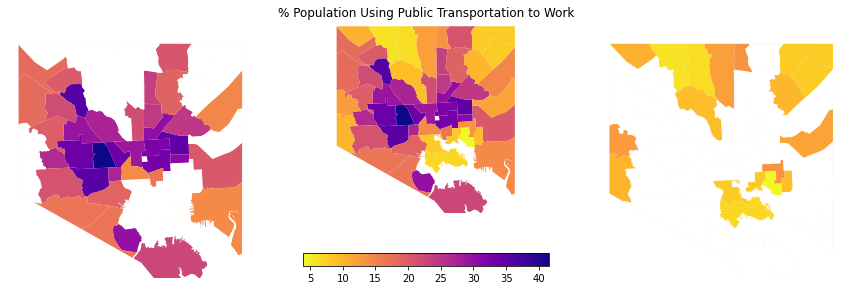

In [123]:
indicator="pubtran19"
title=api_shortname[indicator[:-2]]
fig_rows=1
fig_cols=3
figsize=(fig_cols*5,fig_rows*5)
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=figsize)
makeButterfly_el(axs, indicator, title)


### Footnote 168 - Max pub tran = Sandtown (42%), Min = Canton (4%)

In [124]:
getMaxMinInfo("pubtran19")

Min= 3.843466108 Canton   Max= 41.52684564 Sandtown-Winchester/Harlem Park


True

<h1 style="text-align: center; color: black">Figure 11</h1>

### Footnote 169 - Correlation between PAA and PubTran = .69

In [125]:
#Correlation coefficient between two indicators
turbo_gdf.corr().loc["paa20","pubtran19"]

0.6861318606140289

In [126]:
turbo_gdf.corr().loc["all_defs","pubtran19"]

0.6207344013582554

In [127]:
turbo_gdf.corr().loc["black_defs","pubtran19"]

0.6646326281752314

Min= 3.843466108 Canton   Max= 41.52684564 Sandtown-Winchester/Harlem Park


Text(0.5, 1.0, 'All Defendants')

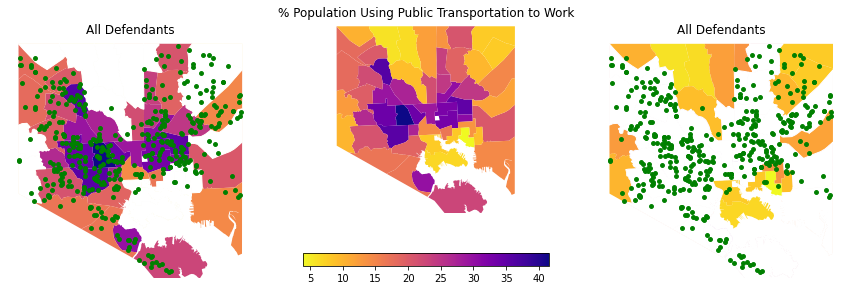

In [128]:
#def scatterIndicator(indicator, use_x_coords = balt_x_coords, use_y_coords= balt_y_coords, scatter_color="black", scatter_size=15)

indicator = "pubtran19"
getMaxMinInfo(indicator)

#Public Transportation
axs=scatterIndicator(indicator, balt_x_coords, balt_y_coords, "green")
title="All Defendants"
axs[0].set_title(title)
axs[2].set_title(title)


### Footnote 174, 175: MHHI indicator is highly correlated to the two variables already discussed: percentage of African American residents (correlation coefficient of -.76) and public transportation (correlation coefficient of -.77). Median household income is also highly correlated to all Baltimore City study defendants (.57)

In [129]:
turbo_gdf.corr().loc["mhhi19", ["pubtran19", "paa20", "all_defs", "black_defs"]]

pubtran19    -0.773399
paa20        -0.755885
all_defs     -0.566499
black_defs   -0.564304
Name: mhhi19, dtype: float64

<h1 style="text-align: center; color: black">Figure 12 + Min/Max MMHI footnote 176</h1> 

Min= 21318.79696 Upton/Druid Heights   Max= 128460.4821 Canton


index                         267
def_index                     267
Psynym              HERBERT Smath
Race                           AA
balr_date     2020-07-01 00:00:00
judge_name               Studdard
Outcome                      HWOB
Long                   -76.532532
Lat                     39.335372
CSA             Cedonia/Frankford
Name: 7, dtype: object

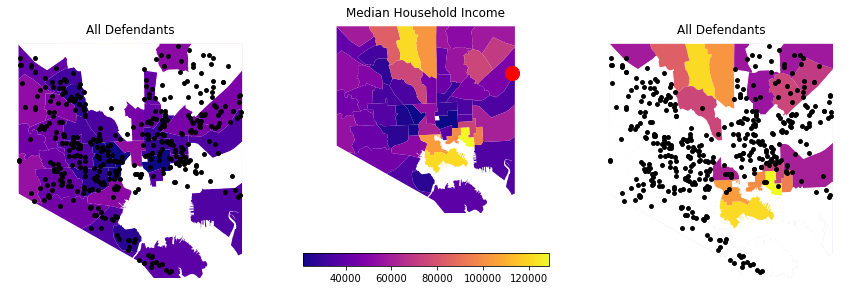

In [130]:
#Median Household Income
indicator = "mhhi19"
getMaxMinInfo(indicator)
axs=scatterIndicator(indicator)

title="All Defendants"
axs[0].set_title(title)
axs[2].set_title(title)

#Scatter code (Quontes Hoffler)
story=7
x=stories_df.loc[story,"Long"]
y=stories_df.loc[story,"Lat"]
axs[1].scatter(x=x, y=y, s=200, color="red")
stories_df.loc[story]


### footnote 177 - Cedonia/Frankford 83% Black and $47K MMH

In [131]:
get_All_CSA_ranks("Cedonia/Frankford")

,Indic,Name,Raw,Rank
paa20,paa20,% Residents Black,82.596304,19.0
femhhs19,femhhs19,X% Female-Led Households w/ Children Under 18,44.222586,34.0
mhhi19,mhhi19,Median Household Income,47258.03394,25.0
hhpov19,hhpov19,% Family Households Below Poverty Line,10.876413,34.0
hhchpov19,hhchpov19,% Children Below Poverty Line,17.905647,35.0
ownroc20,ownroc20,% Housing Units Owner-Occupied,68.816521,14.0
vacant20,vacant20,% Residential Properties Vacant and Abandoned,1.191422,35.0
nohhint19,nohhint19,% Households w/ No Home Internet,16.438654,37.0
tanf19,tanf19,% Families Receiving TANF,6.41655,29.0
lifexp18,lifexp18,Life Expectancy,71.840653,32.0


In [132]:
turbo_gdf.corr().loc["mhhi19", ["pubtran19", "paa20", "all_defs", "black_defs"]]

pubtran19    -0.773399
paa20        -0.755885
all_defs     -0.566499
black_defs   -0.564304
Name: mhhi19, dtype: float64

### SMATH - Footnote 177

In [133]:
#Smath (Hoffler)
charges_df[charges_df.def_index==267]

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
168,168,267,0B02420565,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,2 0105,PEACE ORDER: FAIL TO COMPLY,CLOSED,TRIAL,OTHER PLEA,DISMISSED,2020-09-24,NaN,NaN


In [134]:
all_defs_df[all_defs_df.def_index==267]

,def_index,Psynym,Race,balr_date,judge_name,Outcome,pretrial_rec,asa_rec,Long,Lat,CSA
267,267,HERBERT Smath,AA,2020-07-01,Studdard,HWOB,HWOB,HWOB,-76.532532,39.335372,Cedonia/Frankford


### Footnote 180 - Smath 85 days in jail

In [135]:
#balr_date for smath = 2020-07-01
bdate = dt.datetime(2020,7,1)

#release date (charge disp date from above) = 2020-09-24
rdate = dt.datetime(2020,9, 24)

#Echo difference between release and BALR in days
(rdate-bdate).days

85

<h1 style="text-align: center; color: black">Figure 13</h1>

In [136]:
top_indic =["paa20","pubtran19","mhhi19", "tanf19","vacant20", "hhchpov19"]

x=top_indic[0:3]
x.append("all_defs")
ans=round(turbo_gdf.corr().loc[x,x],2)
ans.to_clipboard()
ans

,paa20,pubtran19,mhhi19,all_defs
paa20,1.00,0.69,-0.76,0.62
pubtran19,0.69,1.00,-0.77,0.62
mhhi19,-0.76,-0.77,1.00,-0.57
all_defs,0.62,0.62,-0.57,1.00


<h1 style="text-align: center; color: black">Figure 14</h1>

In [139]:
x=["tanf19", "nohhint19", "voted18", "all_defs"]
ans=round(turbo_gdf.corr().loc[x,x],2)
ans.to_clipboard()
ans

,tanf19,nohhint19,voted18,all_defs
tanf19,1.00,0.72,-0.81,0.58
nohhint19,0.72,1.00,-0.79,0.61
voted18,-0.81,-0.79,1.00,-0.60
all_defs,0.58,0.61,-0.60,1.00


### Footnote 183 - Highest and Lowest TANF and home internet + Footnote 184 Higest and Lowest VOTING

In [140]:
for indic in x[:-1]:
    print(indic, api_shortname[indic[:-2]])
    getMaxMinInfo(indic)

tanf19 % Families Receiving TANF
Min= 0.363901019 Canton   Max= 18.65889213 Cherry Hill
nohhint19 % Households w/ No Home Internet
Min= 3.963221306 Greater Roland Park/Poplar Hill   Max= 38.84334146 Sandtown-Winchester/Harlem Park
voted18 % Over 18 Population Voted General Election
Min= 27.97988265 Brooklyn/Curtis Bay/Hawkins Point   Max= 70.61371841 Greater Roland Park/Poplar Hill


In [137]:
def Triple_scatterIndicator(indicators, use_x_coords = balt_x_coords, use_y_coords= balt_y_coords, scatter_color="black", scatter_size=15):
    titles=[]
    for indic in indicators:
        titles.append(api_shortname[indic[:-2]])

    fig_rows=len(indicators)
    fig_cols=3
    figsize=(fig_cols*5,fig_rows*5)
    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=figsize)
    for n in range (fig_rows):
        makeButterfly_el(axs[n,], indicators[n], titles[n])
        axs[n, 0].scatter(x=use_x_coords, y=use_y_coords, s=scatter_size, color=scatter_color)
        axs[n, 2].scatter(x=use_x_coords, y=use_y_coords, s=scatter_size, color=scatter_color)
    return axs


<h1 style="text-align: center; color: black">Figure 15</h1>

Min= 63.1591764 Downtown/Seton Hill   Max= 84.71839043 Cross-Country/Cheswolde


index                          82
def_index                      82
Psynym          Dionicio Wordrick
Race                           AA
balr_date     2020-06-10 00:00:00
judge_name                  Smith
Outcome                      HWOB
Long                   -76.617872
Lat                     39.295866
CSA                       Midtown
Name: 1, dtype: object

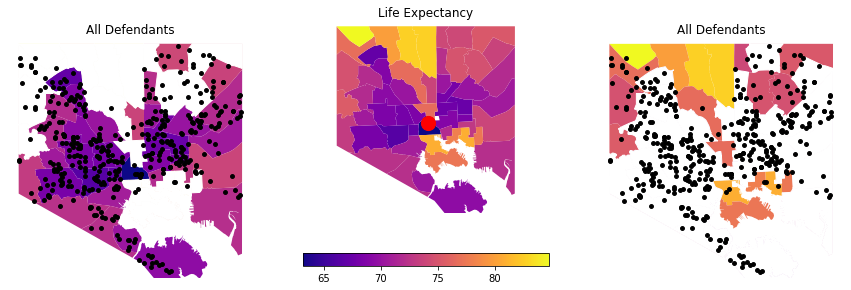

In [138]:
#Life Expectancy
indicator = "lifexp18"
getMaxMinInfo(indicator)
axs=scatterIndicator(indicator)

title="All Defendants"
axs[0].set_title(title)
axs[2].set_title(title)

story=1 #(Dionicio Wordrick)
x=stories_df.loc[story,"Long"]
y=stories_df.loc[story,"Lat"]
axs[1].scatter(x=x, y=y, s=200, color="red")
stories_df.loc[story]

In [141]:
#Wordrick's Neighborhood - 'Midtown'
get_All_CSA_ranks("Midtown")

,Indic,Name,Raw,Rank
paa20,paa20,% Residents Black,29.896485,41.0
femhhs19,femhhs19,X% Female-Led Households w/ Children Under 18,28.603104,45.0
mhhi19,mhhi19,Median Household Income,53663.69609,20.0
hhpov19,hhpov19,% Family Households Below Poverty Line,6.522883,41.0
hhchpov19,hhchpov19,% Children Below Poverty Line,13.172043,41.0
ownroc20,ownroc20,% Housing Units Owner-Occupied,40.331808,39.0
vacant20,vacant20,% Residential Properties Vacant and Abandoned,1.172769,36.0
nohhint19,nohhint19,% Households w/ No Home Internet,12.428587,44.0
tanf19,tanf19,% Families Receiving TANF,5.3407,32.0
lifexp18,lifexp18,Life Expectancy,76.705063,11.0


In [142]:
#Wordrick - BALR date
all_defs_df[all_defs_df.def_index==82]

,def_index,Psynym,Race,balr_date,judge_name,Outcome,pretrial_rec,asa_rec,Long,Lat,CSA
82,82,Dionicio Wordrick,AA,2020-06-10,Smith,HWOB,HWOB,HWOB,-76.617872,39.295866,Midtown


### Footnote 196 - Wordrick charges NP'd

In [143]:
#Wordrick - Nolle Prosse date
charges_df[charges_df.def_index==82]

,index,def_index,casenumber,courtsystem,charge_no,cjis_code,charge_name,status,case_disp,plea,charge_disp,charge_disp_date,trialdate,trialtype
614,615,82,2B02416766,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,1,2 3030,BURGLARY- 4TH DEGREE-DWELL,CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-09-24,NaN,NaN
615,616,82,2B02416766,DISTRICT COURT FOR BALTIMORE CITY - CRIMINAL S...,2,3 4025,"MAL DEST PROP/VALU < $1,000",CLOSED,TRIAL,OTHER PLEA,NOLLE PROSEQUI,2020-09-24,NaN,NaN


### Footnote 196 - Wordrick 106 days in jail

In [144]:
#balr_date for Wordrick = 2020-06-10
bdate = dt.datetime(2020,6,10)

#release date (charge disp date from above) = 2020-09-24
rdate = dt.datetime(2020,9, 24)

#Echo difference between release and BALR in days
(rdate-bdate).days

106

In [145]:
turbo_gdf.corr().loc["lifexp18", ["paa20", "all_defs"]]

paa20      -0.680775
all_defs   -0.654898
Name: lifexp18, dtype: float64

## Map below DID NOT make it into Article

lifexp18 Life Expectancy
Min= 63.1591764 Downtown/Seton Hill   Max= 84.71839043 Cross-Country/Cheswolde
vacant20 % Residential Properties Vacant and Abandoned
Min= 0.099009900990099 Greater Roland Park/Poplar Hill   Max= 31.951871657754 Sandtown-Winchester/Harlem Park


index                          82
def_index                      82
Psynym          Dionicio Wordrick
Race                           AA
balr_date     2020-06-10 00:00:00
judge_name                  Smith
Outcome                      HWOB
Long                   -76.617872
Lat                     39.295866
CSA                       Midtown
Name: 1, dtype: object

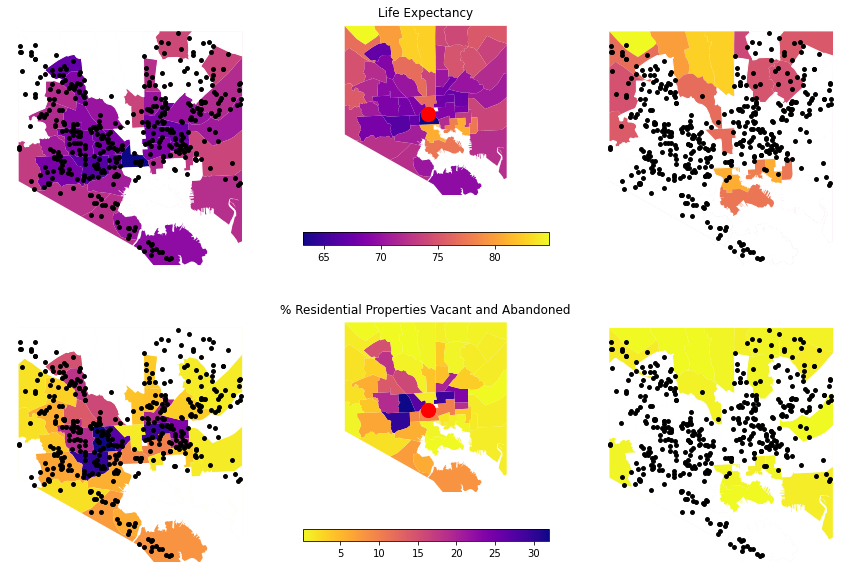

In [146]:
indicators=["lifexp18", "vacant20"]
for indic in indicators:
    print(indic, api_shortname[indic[:-2]])
    getMaxMinInfo(indic)
axs= Triple_scatterIndicator(indicators)

story=1
x=stories_df.loc[story,"Long"]
y=stories_df.loc[story,"Lat"]
axs[0,1].scatter(x=x, y=y, s=200, color="red")
axs[1,1].scatter(x=x, y=y, s=200, color="red")
stories_df.loc[story]


In [147]:
get_All_CSA_ranks("Midtown")

,Indic,Name,Raw,Rank
paa20,paa20,% Residents Black,29.896485,41.0
femhhs19,femhhs19,X% Female-Led Households w/ Children Under 18,28.603104,45.0
mhhi19,mhhi19,Median Household Income,53663.69609,20.0
hhpov19,hhpov19,% Family Households Below Poverty Line,6.522883,41.0
hhchpov19,hhchpov19,% Children Below Poverty Line,13.172043,41.0
ownroc20,ownroc20,% Housing Units Owner-Occupied,40.331808,39.0
vacant20,vacant20,% Residential Properties Vacant and Abandoned,1.172769,36.0
nohhint19,nohhint19,% Households w/ No Home Internet,12.428587,44.0
tanf19,tanf19,% Families Receiving TANF,5.3407,32.0
lifexp18,lifexp18,Life Expectancy,76.705063,11.0


## Code for CODA -- Summer 2021 Research

In [148]:
# Get Summer Research
summer_df = pd.read_csv("summer2021_coda.csv")
summer_df

,Casenumber,BALR Date,Judge Name,Outcome,Race,Pretrial Rec,ASA rec,Def rec
0,6B02430581,2021-05-18,Etheridge,UPB,Unknown,ROR,NB,ROR HD
1,3B02438320,2021-05-18,Etheridge,HWOB,AA,NB,HD,ROR
2,1B02438577,2021-05-18,Etheridge,HWOB,AA,NB,NB,UPB with pretrial supervision
3,4B02436193,2021-05-18,Etheridge,HWOB,AA,NB,NB,UPB and stay away
4,0B02438576,2021-05-18,Etheridge,HWOB,AA,NB,NB,UPB
...,...,...,...,...,...,...,...,...
111,UNABLE TO CONFIRM NAME OR CASE NUMBER,2021-06-01,Greene,HWOB,NaN,NB,NB,ROR
112,D023CR21000548,2021-06-01,Greene,UPB,AA,NB - high risk,HD,ROR
113,4B02438664,2021-06-01,Greene,UPB,AA,NB - high risk,HD,ROR
114,2B02438662,2021-06-01,Greene,UPB,AA,NB - low risk,NB,ROR


In [149]:
#Find incomplete values
summer_df[summer_df.Race.isna()]

,Casenumber,BALR Date,Judge Name,Outcome,Race,Pretrial Rec,ASA rec,Def rec
17,NA - 2103252,2021-05-20,Studdard,HWOB,NaN,NB - high risk,NB,No recommendation
90,unk,2021-05-26,Dorsey,HWOB,NaN,No recommendation,No recommendation,No recommendation
111,UNABLE TO CONFIRM NAME OR CASE NUMBER,2021-06-01,Greene,HWOB,NaN,NB,NB,ROR
115,1B02435560,2021-06-11,Dunn,HWOB,NaN,ROR,HD,HD


In [150]:
#Drop incomplete
summer_df=summer_df.drop([17,111, 90, 115])

### Footnote 201 - Attended 112 hearings

In [151]:
#Total number of hearings
len(summer_df)

112

### Footnote 201 - 10 different judges

In [152]:
#Total number of judges
len(summer_df["Judge Name"].unique())

10

### Footnote 202, 204 - Detention rates + ROR number

In [153]:
#Outcome percentages
a=summer_df["Outcome"].value_counts()
b=round(summer_df["Outcome"].value_counts(normalize=True)*100,2)

fig_df=pd.DataFrame(a)
fig_df["Pct"]=b.values

fig_df.to_clipboard()
fig_df

,Outcome,Pct
HWOB,78,70.91
ROR,16,14.55
UPB,14,12.73
Bond,1,0.91
HD,1,0.91


In [154]:
#Race percentages
a=summer_df["Race"].value_counts()
b=round(summer_df["Race"].value_counts(normalize=True)*100,2)

fig_df=pd.DataFrame(a)
fig_df["Pct"]=b.values

fig_df.to_clipboard()
fig_df

,Race,Pct
AA,95,84.82
White,9,8.04
Unknown,8,7.14


### Footnote 205 - Black and white HWOB rates

In [155]:
#Black HWOB rate
round(summer_df[summer_df.Race=="AA"]["Outcome"].value_counts(normalize=True),2)

HWOB    0.75
ROR     0.15
UPB     0.09
HD      0.01
Name: Outcome, dtype: float64

In [156]:
#White HWOB rate
round(summer_df[summer_df.Race=="White"]["Outcome"].value_counts(normalize=True),2)

HWOB    0.62
UPB     0.25
ROR     0.12
Name: Outcome, dtype: float64

### Footnote 206 - Black and white overall percentages in summer study

In [157]:
summer_df.Race.value_counts(normalize=True)

AA         0.848214
White      0.080357
Unknown    0.071429
Name: Race, dtype: float64

In [158]:
# Days of study
summer_df["BALR Date"].unique()

array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
       '2021-05-24', '2021-05-25', '2021-05-26', '2021-05-27',
       '2021-05-28', '2021-06-01'], dtype=object)

In [159]:
len(summer_df["BALR Date"].unique())

10

In [160]:
# Original Study All judges - Percentages
judges= all_defs_df.judge_name.unique()
columns = all_defs_df.Outcome.unique()
result_df=pd.DataFrame(index=judges, columns=columns)

for judge, sub_df in all_defs_df.groupby("judge_name"):
    result_row=round(sub_df["Outcome"].value_counts(normalize=True)*100,2)
    result_df.loc[judge]=result_row

result_df= result_df.sort_values(by="HWOB", ascending=False)
result_df.loc["AVG"]=result_df.mean(axis=0)
result_df.loc["MED"]=result_df.median(axis=0)
result_df=result_df.fillna("-")
result_df

,UPB,HWOB,ROR,MONEY,ROR-HDTN
Kerry,-,100.000000,-,-,-
Dunn,-,80.490000,-,19.51,-
Smith,20.69,79.310000,-,-,-
Pastore,-,77.780000,11.11,-,11.11
Hengrer,15.38,76.920000,7.69,-,-
Chen,26.42,73.580000,-,-,-
Dorsey,-,68.570000,25.71,5.71,-
Studdard,-,64.520000,30.65,3.23,1.61
Etheridge,37.5,62.500000,-,-,-
Greene,26.09,60.870000,13.04,-,-


In [161]:
result_df = result_df.drop(["AVG","MED"])

### Footnote 152 - 6 of 16 judges with higher than 70% HWOB

In [ ]:
#Number of judges with higher than 70% HWOB rate
len(result_df[result_df.HWOB>70])

In [ ]:
#Percent holding > 70%
6/16

In [ ]:
# Summer Study All judges - Percentages
judges= summer_df["Judge Name"].unique()
columns = summer_df.Outcome.unique()
result_df=pd.DataFrame(index=judges, columns=columns)

for judge, sub_df in summer_df.groupby("Judge Name"):
    result_row=round(sub_df["Outcome"].value_counts(normalize=True)*100,2)
    result_df.loc[judge]=result_row

result_df= result_df.sort_values(by="HWOB", ascending=False)
result_df.loc["AVG"]=result_df.mean(axis=0)
result_df.loc["MED"]=result_df.median(axis=0)
result_df=result_df.fillna(0)
result_df

In [ ]:
result_df = result_df.drop(["AVG","MED"])

print("Number of judge", len(result_df))

#Number of judges with higher than 70% HWOB rate
len(result_df[result_df.HWOB>70])

In [ ]:
#percent judges higher than 70%
7/10

# END